@Author Simon Schuler

# Resampling sound from 48kHz to 16kHz

We at VIVAI had a hard time to find good information on how to **continously** resample live sound between different frame rates. 
So I descided to have a closer look at the most recommended libraries. 

In the **first part** I visually compare different libraries with a freqzency sweep from 0 to 24,000 Hz. 

In the **second part** I measure performance of different libraries.

In the **third part** I use a realworld example to show that continuous resampling is a very important feature if you get sound live from a microphone for example.


All this is published by VIVAI under the MIT license.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
import resampy
import nnresample 
import librosa
import samplerate

import IPython.display as ipd

In [2]:
from_freq = 48000
to_freq = 16000

# Frequency Sweep, as example

### Original Sound:

In [3]:
#genearte frequency sweep
offset = 2000
instfreq = np.exp(np.linspace(np.log(offset+100), np.log(offset+23900), 96000))-offset
deltaphase = 2*np.pi*instfreq/48000
cphase = np.cumsum(deltaphase)
sig = np.sin(cphase)

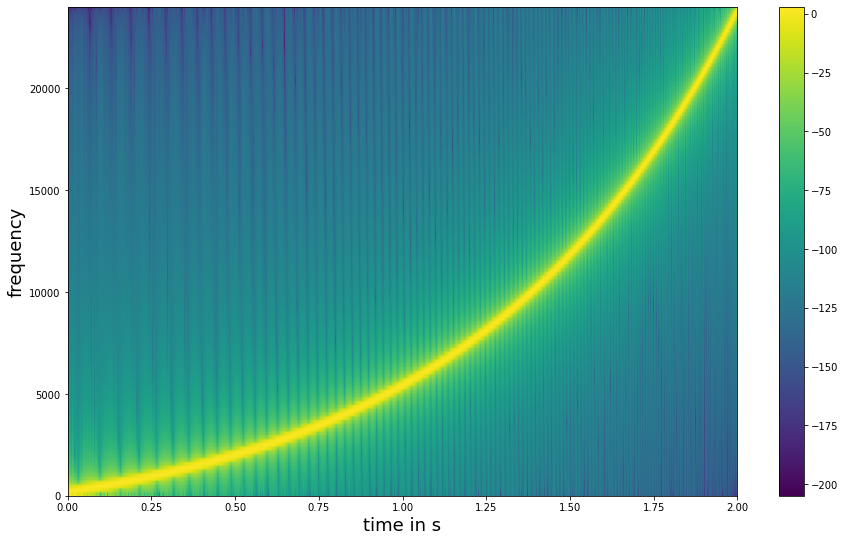

In [4]:
signal = sig
plt.figure(figsize=(15,9))
plt.specgram(sig*30, scale='dB', Fs=from_freq, NFFT=256)
plt.colorbar()
plt.axis((0,2,0,24000))
plt.ylabel("frequency", fontsize=18)
plt.xlabel("time in s", fontsize=18)
ipd.Audio(sig, rate=48000)

### SciPy.signal.resample_poly

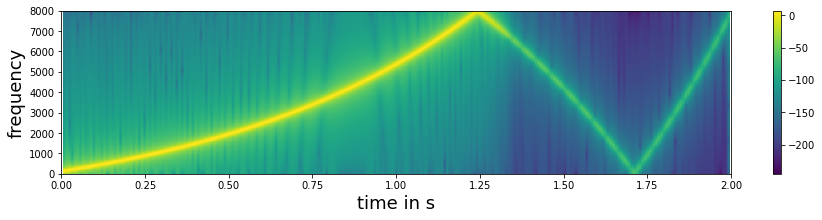

In [5]:
signal = scipy.signal.resample_poly(sig, to_freq, from_freq)
plt.figure(figsize=(15,3))
plt.specgram(signal*30, scale='dB', Fs=to_freq, NFFT=256)
plt.colorbar()
plt.axis((0,2,0,to_freq/2))
plt.ylabel("frequency", fontsize=18)
plt.xlabel("time in s", fontsize=18)
ipd.Audio(signal, rate=to_freq)

### Resampy

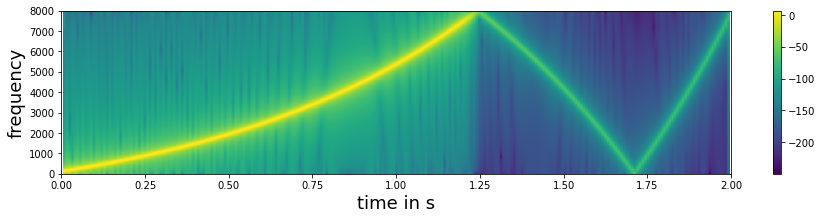

In [6]:
signal = resampy.resample(sig, from_freq, to_freq)
plt.figure(figsize=(15,3))
plt.specgram(signal*30, scale='dB', Fs=to_freq, NFFT=256)
plt.colorbar()
plt.axis((0,2,0,to_freq/2))
plt.ylabel("frequency", fontsize=18)
plt.xlabel("time in s", fontsize=18)
ipd.Audio(signal, rate=to_freq)

### nnresample

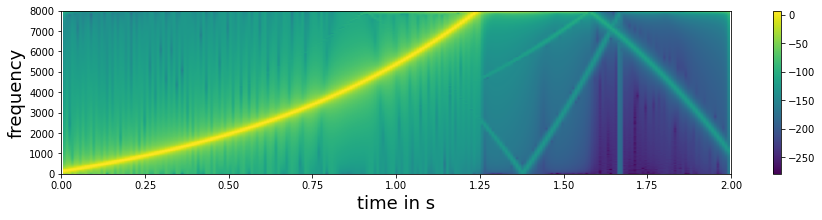

In [7]:
signal = nnresample.resample(sig, to_freq, from_freq)
plt.figure(figsize=(15,3))
plt.specgram(signal*30, scale='dB', Fs=to_freq, NFFT=256)
plt.colorbar()
plt.axis((0,2,0,to_freq/2))
plt.ylabel("frequency", fontsize=18)
plt.xlabel("time in s", fontsize=18)
ipd.Audio(signal, rate=to_freq)

### librosa

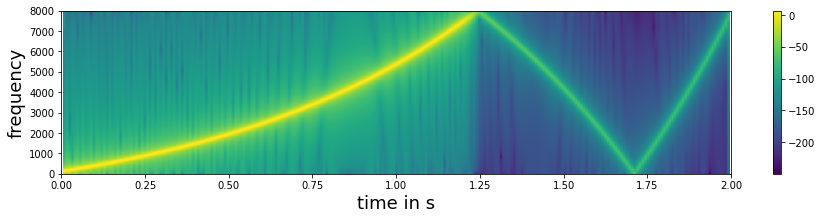

In [8]:
signal = librosa.resample(sig, from_freq, to_freq)
plt.figure(figsize=(15,3))
plt.specgram(signal*30, scale='dB', Fs=to_freq, NFFT=256)
plt.colorbar()
plt.axis((0,2,0,to_freq/2))
plt.ylabel("frequency", fontsize=18)
plt.xlabel("time in s", fontsize=18)
ipd.Audio(signal, rate=to_freq)

### samplerate.converters (best)

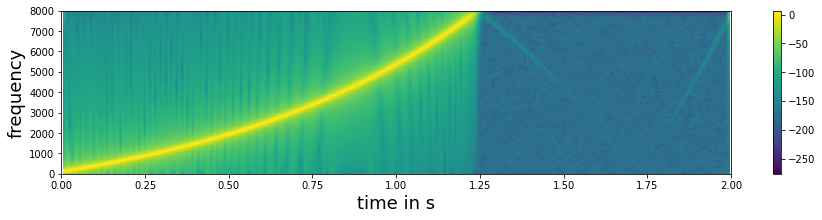

In [9]:
signal = samplerate.resample(sig, to_freq/from_freq, "sinc_best")
plt.figure(figsize=(15,3))
plt.specgram(signal*30, scale='dB', Fs=to_freq, NFFT=256)
plt.colorbar()
plt.axis((0,2,0,to_freq/2))
plt.ylabel("frequency", fontsize=18)
plt.xlabel("time in s", fontsize=18)
ipd.Audio(signal, rate=to_freq)

### samplerate.converters (fastest)

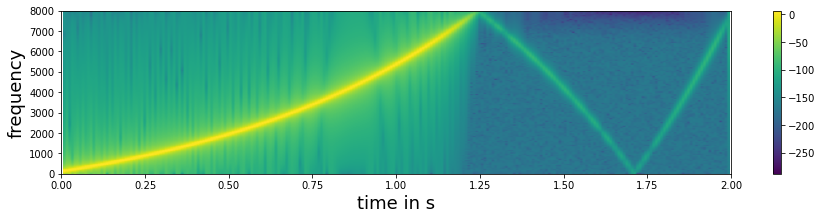

In [10]:
signal = samplerate.resample(sig, to_freq/from_freq, "sinc_fastest")
plt.figure(figsize=(15,3))
plt.specgram(signal*30, scale='dB', Fs=to_freq, NFFT=256)
plt.colorbar()
plt.axis((0,2,0,to_freq/2))
plt.ylabel("frequency", fontsize=18)
plt.xlabel("time in s", fontsize=18)
ipd.Audio(signal, rate=to_freq)

# Result:

SciPy.signal is probably not a good algo. Just look at the yellow drop after it reaches 8kHz. Its way worse than the others.

From what I can see, id argue that resampy and librosa are using the same algorythm.

Id argue that samplerate.resample.best is probably the best, due to the homogenous nature of the part after it reaches 8kHz. 

# Measure execution time

In [11]:
#careful, depending on your pc this can take multiple minutes

print("SciPy.signal.resample_poly")
%timeit -n 5 -r 50 signal = scipy.signal.resample_poly(sig, to_freq, from_freq)
print("\n\nresampy.resample")
%timeit -n 5 -r 50 signal = resampy.resample(sig, from_freq, to_freq)
print("\n\nlibrosa.resample")
%timeit -n 5 -r 50 signal = librosa.resample(sig, from_freq, to_freq)
print("\n\nsamplerate.resample (best)")
%timeit -n 5 -r 50 signal = samplerate.resample(sig, to_freq/from_freq, "sinc_best")
print("\n\nsamplerate.resample (fastest)")
%timeit -n 5 -r 50 signal = samplerate.resample(sig, to_freq/from_freq, "sinc_fastest")
print("\n\nSKIPPING nnresample, it takes about 1.25 seconds (on my pc), this is just not gonna work on a raspberry pi")

SciPy.signal.resample_poly
3.1 ms ± 201 µs per loop (mean ± std. dev. of 50 runs, 5 loops each)


resampy.resample
74.1 ms ± 9.47 ms per loop (mean ± std. dev. of 50 runs, 5 loops each)


librosa.resample
78.5 ms ± 7.09 ms per loop (mean ± std. dev. of 50 runs, 5 loops each)


samplerate.resample (best)
114 ms ± 17.5 ms per loop (mean ± std. dev. of 50 runs, 5 loops each)


samplerate.resample (fastest)
13.6 ms ± 966 µs per loop (mean ± std. dev. of 50 runs, 5 loops each)


SKIPPING nnresample, it takes about 1.25 seconds (on my pc), this is just not gonna work on a raspberry pi


# Result: 
I'm pretty sure we can ignore 

resampy, 
nnresample, 
librosa, 
samplerate.resample(best) 

due to the performance

# Realworld example

resample sound that is in batches and not just one sample done all at once. 

In [12]:
import soundfile as sf

def chunks(lst, n):
    """yield subset of len n from list"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

### Original Sound

In [13]:
# the sound was downloaded from https://freesound.org/people/andriala/sounds/27783/

data, sample_rate = sf.read("waltz.flac")
from_freq = sample_rate

# Resampling in batches of 1024 values (like live audio from a mic)

### samplerate.converters (best)

In [14]:
signal = np.empty([0])
for chunk in chunks(data, 1024):
    s = samplerate.resample(chunk, (to_freq/from_freq)/2, "sinc_best")
    signal = np.append(signal, s)

ipd.Audio(signal, rate=16000)

### samplerate.converters (fastest)

In [15]:
signal = np.empty([0])
for chunk in chunks(data, 1024):
    s = samplerate.resample(chunk, (to_freq/from_freq)/2, "sinc_fastest")
    signal = np.append(signal, s)

ipd.Audio(signal, rate=16000)

# Result:

Everything sounds kind of metallic with very high frequency spikes in between. This is terrible. 

I think this clearly shows that it dosent matter the quality of the resampling if we cant make the transitions between blocks of streamed data better.

## Lets try the streaming variant of samplerate.converters

using: https://pypi.org/project/samplerate/

### best

In [16]:
#set up the streaming-converter 
resampler = samplerate.Resampler("sinc_best", channels=2)

signal = np.empty([0])
for chunk in chunks(data, 1024):
    s = resampler.process(chunk, (to_freq/from_freq)/2, end_of_input=False)
    signal = np.append(signal, s)
    
ipd.Audio(signal, rate=16000)

### fastest

In [17]:
#set up the streaming-converter 
resampler = samplerate.Resampler("sinc_fastest", channels=2)

signal = np.empty([0])
for chunk in chunks(data, 1024):
    s = resampler.process(chunk, (to_freq/from_freq)/2, end_of_input=False)
    signal = np.append(signal, s)
    
ipd.Audio(signal, rate=to_freq)

## Result: 

Sounds way better. This concludes: For **continuous** (and live) sound resampling in python samplerate.Resampler() should be the choice. Depending on your performance needs I'd recommend the use of sinc_best, but the performance difference between best and fastest is HUGE, while I personally dont see such a huge difference in quality.  